In [504]:
#visualization libraries
import plotly
import plotly.graph_objs as go
import plotly.tools as tls
import cufflinks as cf
cf.go_offline()
plotly.offline.init_notebook_mode(connected = True)
import ipywidgets
from ipywidgets import interact, interactive, fixed, interact_manual

import matplotlib as plt
%matplotlib inline

#basic imports
import pandas as pd
import numpy as np
import glob

#presentation snippets
import IPython.core.display as di
#hide code when exported to html
#https://protips.maxmasnick.com/hide-code-when-sharing-ipython-notebooks
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

In [513]:
import pygsheets

In [505]:
#machine learning libraries
from sklearn.cluster import MiniBatchKMeans, KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.pipeline import Pipeline

# Lifting

In [557]:
def format_columns(df):
    '''impute workout characteristics'''
    df.columns = (df.columns
                  .str.strip()
                  .str.lower()
                  .str.replace(' \(lbs\)', '')
                  .str.replace(' ', '_') #remove the (lbs) subtitle on from weight
                 )
    return df

In [558]:
def impute_workout_features(df, routines):
    #set up datetime index
    df['date'] = pd.to_datetime(df.date)
    
    #calculate total volume
    df['volume'] = df.eval('weight * reps')
    
    #calculate speed for cardio
    df['time'] = pd.to_datetime(df.time)
    df['time'] = df.time.dt.minute * 60 + df.time.dt.second
    df['speed'] = df.eval('distance / time')
    
    #impute workout day by the max number of lifts in a category
    df['workout_day'] = df.groupby('date').category.transform(lambda s: s.value_counts(ascending = False).index[0])
    
    #determine completed sets
    df['set_completed'] = np.where(df.weight > 0, 1, 0)
    
    #determine Epley-formulated 1-rep max based
    df['one_rep_max'] = df.eval('weight + weight * reps / 30')
    
    df['routine'] = np.where(routines)
    
    #set index as date for resampling later
    df = df.set_index('date')
    
    return df

def create_gains_matrix(df):
    '''Create matrix of aggregated key performance indicators for workouts'''
    #remove cardio workouts
    df = df.loc[df.category != 'Cardio']
    #get key performance indicators for the workout
    gains = df.pivot_table(index = 'date', 
                           values = ['volume', 'reps', 'weight', 'workout_day', 'set_completed', 'one_rep_max', 'routine'],
                           aggfunc = {'volume': 'sum', 
                                            'reps': 'mean', 
                                            'weight': 'max', 
                                            'one_rep_max': 'max',
                                            'workout_day': 'max',
                                            'set_completed': 'mean',
                                            'routine': 'max'
                                           })
    return gains

def get_lifting_routines():
    '''Get list of weightlifting routines from Google Sheets'''
    #authorize the notebook to access my google sheets
    gc = pygsheets.authorize()
    
    #get routines
    routines = (gc
                .open_by_key('1AdK8q1MEQzBJKWpN46nUVsrdmgq4K79l7aAPkI-uKFo') #open the workbook object using the google sheet key from the url
                .worksheet_by_title("routines") #connect to the spreadsheet tab where the routines are
                .get_as_df(empty_value = np.NaN) #convert to dataframe and fill empty cells with NaN
                .dropna(how = 'all') #drop all completely empty rows
                .dropna(how = 'all', axis = 1)) #drop all completely empty columns
    
    return routines

def plot_gains(df):
    f = go.FigureWidget()
    for i in df.labels.unique():
        df = df[df.labels == i]
        f.add_scatter(x = df.volume, y = df.reps,
                    mode = 'text', marker = {'opacity': .5}, name = str(i))
    return f

In [545]:
fitnotes = pd.read_csv('fitnotes/FitNotes_Export.csv')
routines = get_lifting_routines().pipe(format_columns)
lifts = fitnotes.pipe(format_columns).pipe(impute_workout_features, routines)
gains = create_gains_matrix(lifts)

In [553]:
routines

Routine Category Start Date End Date
0  Princess Diana's Gains Guide    Chest    5/18/18  3/20/18
1  Princess Diana's Gains Guide      Abs     8/4/18  3/20/18

In [ ]:
routine

In [550]:
lifts.index

DatetimeIndex(['2014-06-07', '2014-06-07', '2014-06-07', '2014-06-07',
               '2014-06-07', '2014-06-07', '2014-06-07', '2014-06-07',
               '2014-06-07', '2014-06-08',
               ...
               '2018-12-15', '2018-12-15', '2018-12-15', '2018-12-15',
               '2018-12-15', '2018-12-15', '2018-12-15', '2018-12-15',
               '2018-12-15', '2018-12-15'],
              dtype='datetime64[ns]', name='date', length=5536, freq=None)

Todo
- Kinds of lifts over time
- General depiction of how often I go to the gym
- Depiction of how much of the workout I complete
- Depiction of how well I stuck to workouts
- Depiction of how much I grew during a particular workout cycle
- Recent trends in total reps, total volume, and max weight by category
- Cluster analysis of lifting kpis
- Add in fitbit sleep analysis and heartrate scores

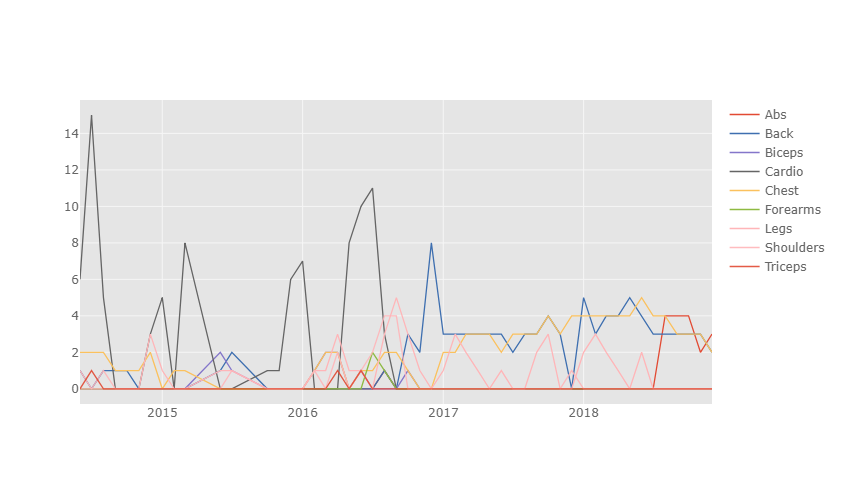

In [508]:
#kinds of lifts over time
lifts.reset_index().drop_duplicates(subset = 'date').set_index('date').groupby([pd.Grouper(freq = 'MS'), 'category']).workout_day.count().unstack().fillna(0).iplot()

In [509]:
#rolling 5 week average of how many times I go to the gym in a week
n_lifts = lifts.drop_duplicates(subset = 'date').set_index('date').resample('W').exercise.count().rolling(5).mean()

KeyError: Index(['date'], dtype='object')

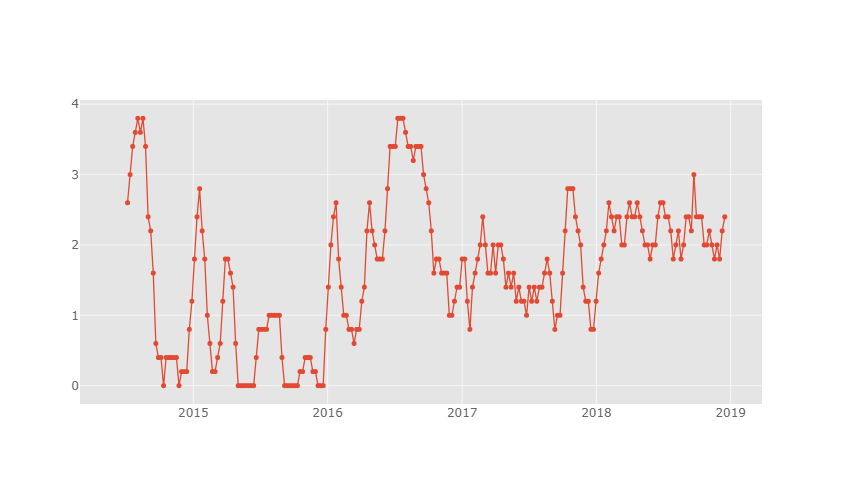

In [510]:
n_lifts.iplot(mode = 'lines+markers', size = 5)

In [511]:
#number of kidns of exercises per month over time
categories = lifts.drop_duplicates(subset = 'date').pivot_table(index = 'date', columns = 'category', values = 'weight', aggfunc = 'count').resample('MS').sum()

KeyError: Index(['date'], dtype='object')

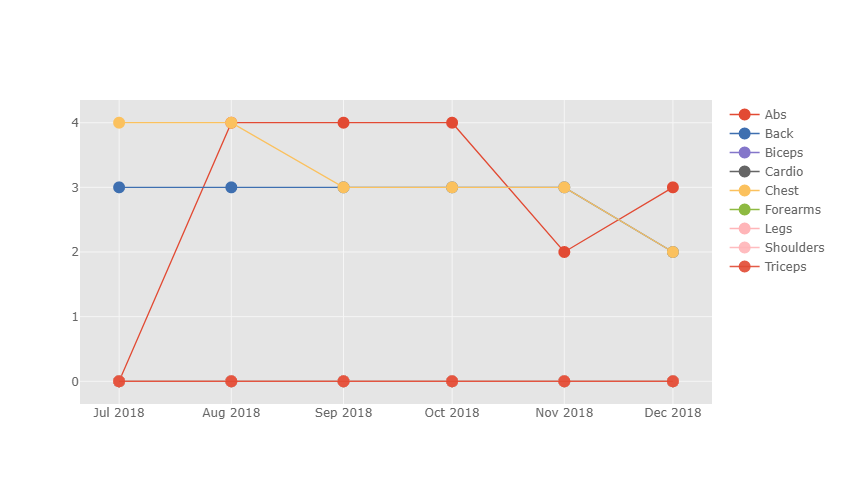

In [8]:
plot_recent_gains(categories)

In [68]:
plot_gains(lifts, 'Chest')

FigureWidget({
    'data': [{'name': 'reps',
              'type': 'scatter',
              'uid': 'fa7926e3-4…

In [11]:
chest_volume = lifts.query('category == "Chest"').pivot_table(index = 'date', values = 'volume', columns = 'exercise', aggfunc = 'sum')

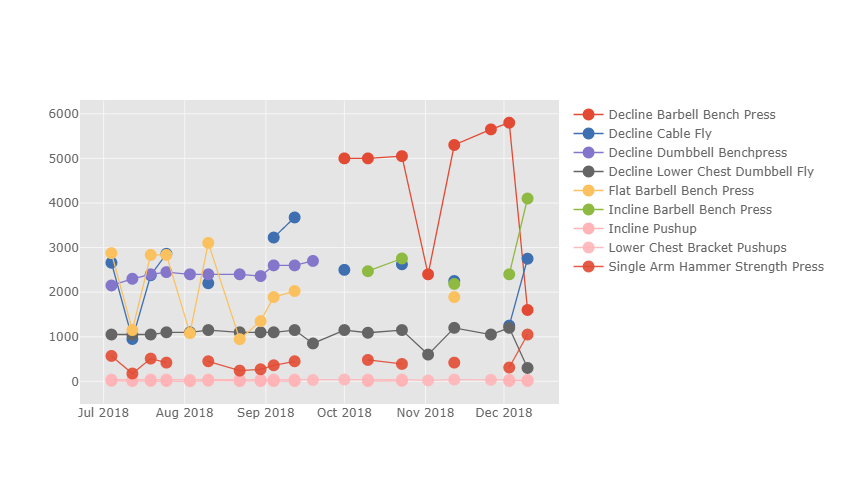

In [12]:
chest_volume.pipe(plot_recent_gains)

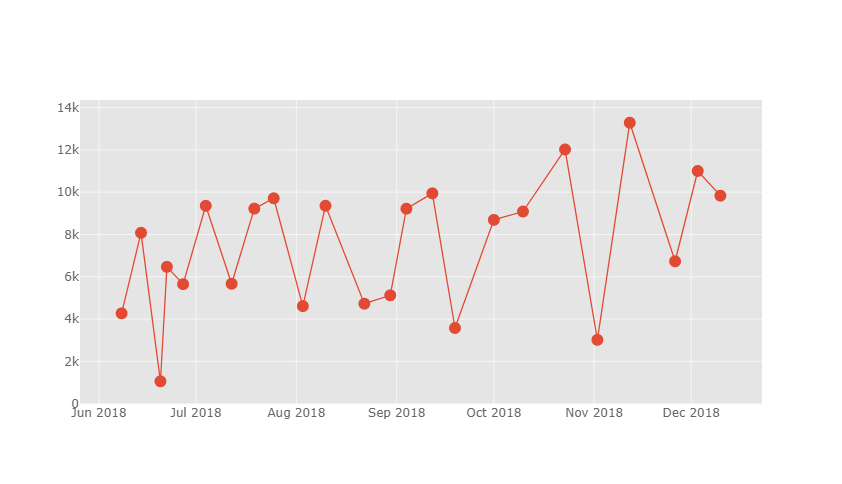

In [39]:
chest_volume.sum(axis = 1).to_frame().pipe(plot_recent_gains)

In [13]:
chest_reps = lifts.query('category == "Chest"').pivot_table(index = 'date', values = 'reps', columns = 'exercise', aggfunc = 'max')

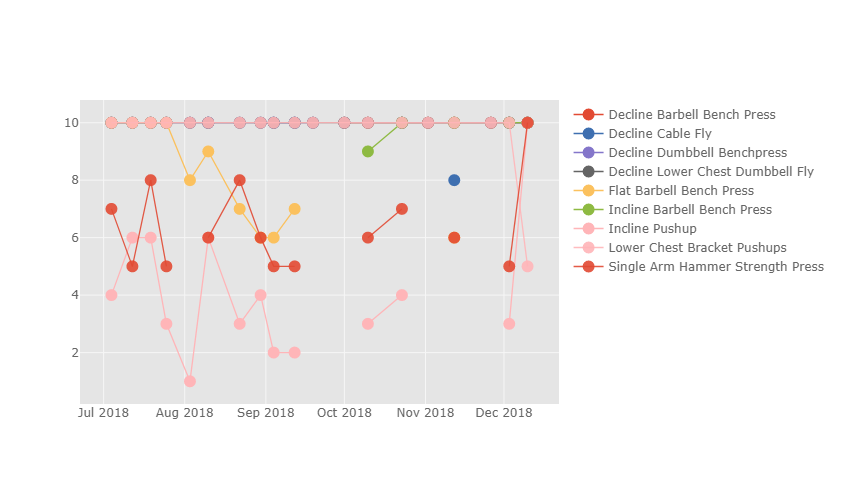

In [14]:
plot_recent_gains(chest_reps)

In [15]:
back_max = lifts.query('category == "Back"').pivot_table(index = 'date', values = 'weight', columns = 'exercise', aggfunc = 'max')

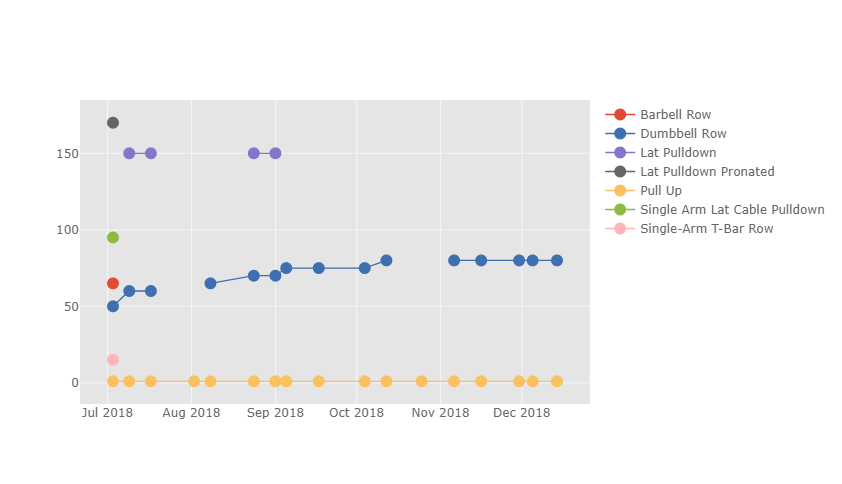

In [16]:
back_max.pipe(plot_recent_gains)

In [17]:
back_volume = lifts.query('category == "Back"').pivot_table(index = 'date', values = 'volume', columns = 'exercise', aggfunc = 'sum')

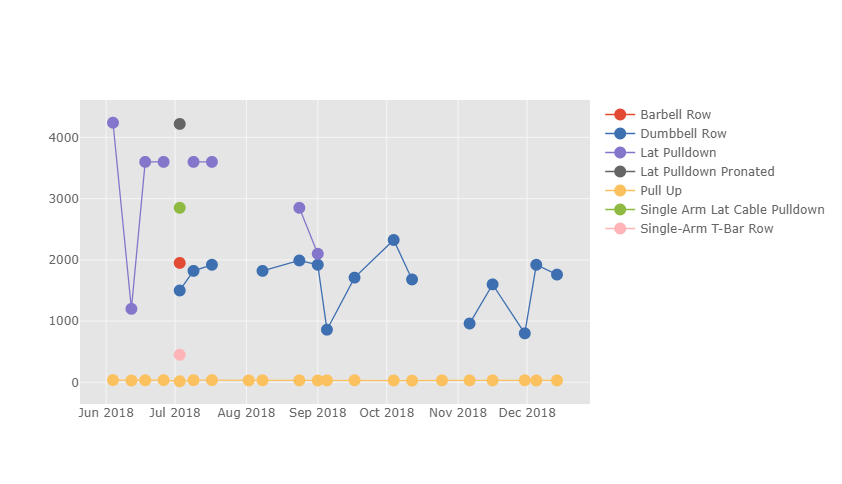

In [40]:
plot_recent_gains(back_volume)

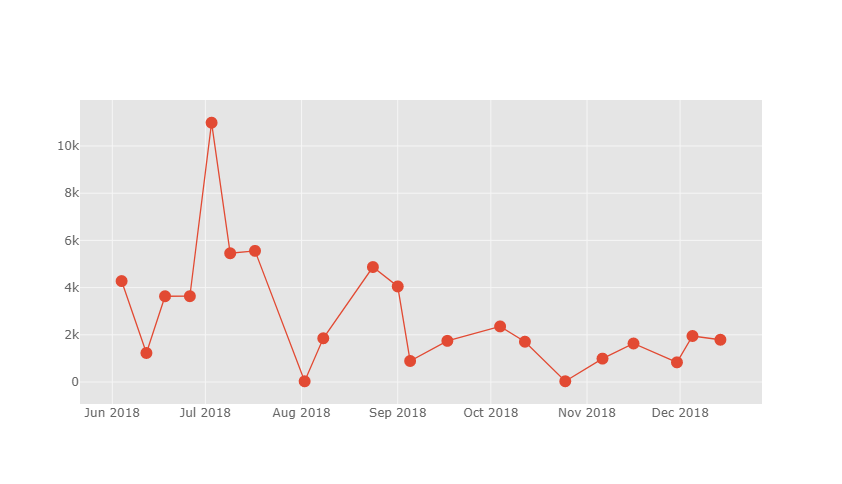

In [38]:
back_volume.sum(axis = 1).to_frame().pipe(plot_recent_gains)

In [19]:
back_reps = lifts.query('category == "Back"').pivot_table(index = 'date', values = 'reps', columns = 'exercise', aggfunc = 'max')

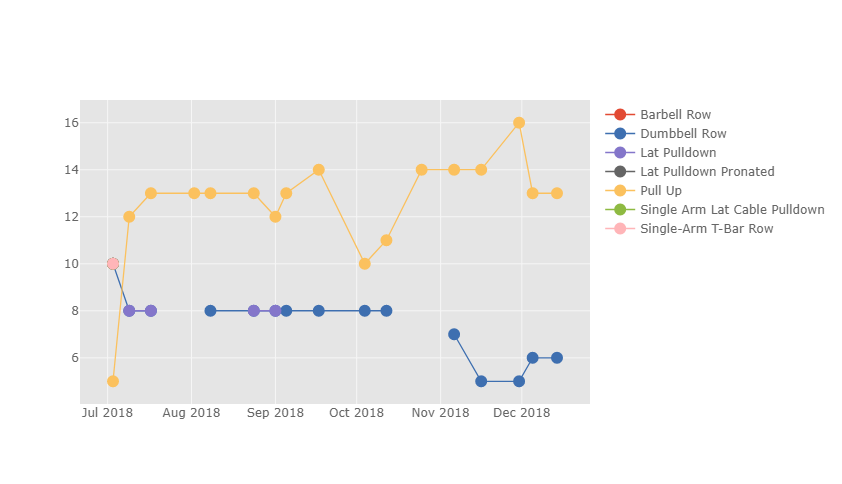

In [20]:
plot_recent_gains(back_reps)

In [21]:
sixpack = lifts.query('category == "Abs"').pivot_table(index = 'date', values = 'reps', columns = 'exercise', aggfunc = 'max')

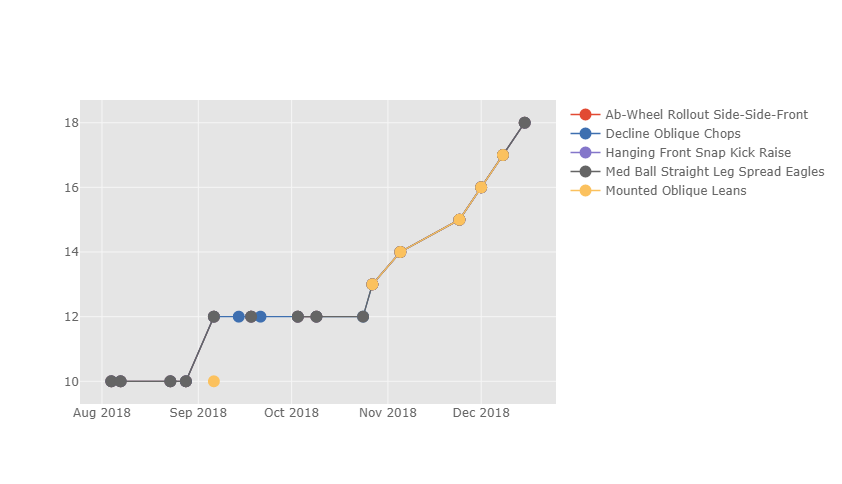

In [22]:
plot_recent_gains(sixpack)

In [464]:
sixpack_reps = lifts.query('category == "Abs"').pivot_table(index = 'date', values = 'reps', columns = 'exercise', aggfunc = 'mean')

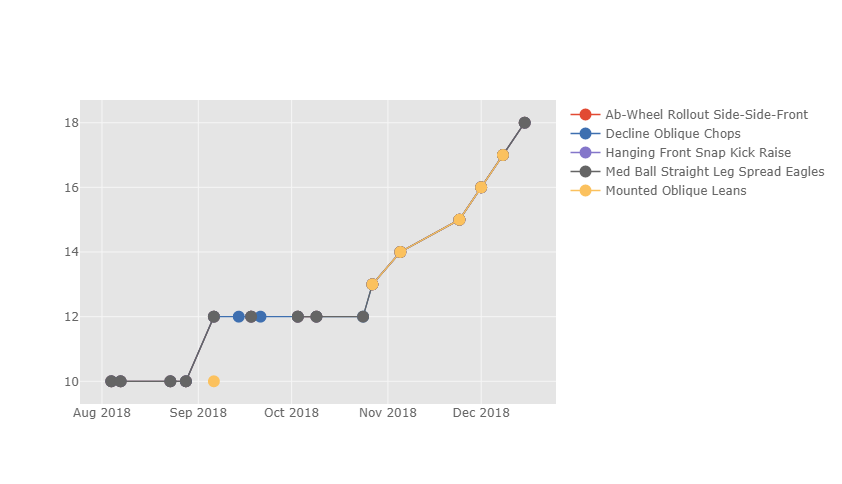

In [465]:
plot_recent_gains(sixpack_reps)

# Cluster Testing

In [463]:
#cluster testing
normalizer = Normalizer()

scaler = StandardScaler()

norm = normalizer.transform(gains.drop('workout_day', axis = 1))

scaled = scaler.fit_transform(norm)

test = pd.DataFrame(scaled)

centroids = []
for i in range(1, 15):
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(test)
    centroids.append(kmeans.inertia_)
centroids = pd.Series(centroids, index = range(1, 15))

kmeans = KMeans(n_clusters = 5)

gains['labels'] = kmeans.fit_predict(test)

f = go.FigureWidget()
for i in gains.labels.unique():
    df = gains[gains.labels == i]
    f.add_scatter3d(x = df.reps, 
                    y = df.weight, 
                    z = df.volume,
                    mode = 'markers',
                    marker = {'opacity': .5},
                    text = df.workout_day)